In [1]:
# Only CPU 약 하루 걸림 @ 테스트 서버

model_path = 'yolo3_trained_trial_1_@_20230601.h5'
model_path_inference = 'yolo3_trained_trial_1_@_20230601_inf.h5'

annotation_path = './yolo_train.txt'
classes_path = './yolo_classes.txt'
anchors_path = './yolo_anchors.txt'

freeze_body = 2 # 1 = "Freeze the first 185 layers of total 252 layers", 2 = Train top 3 layers, 3 = Train top 9 layers
batch_size = 32
learning_rate = 0.001 # 0.001 = 1e-3
random_aug = True

import os # Protocol Buffers to use Python rather than C++
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

## GPU에 할당(사용)되는 메모리 크기 제한
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
gpu_memory_limit=1024*12 # only allocate 12GB of memory on the gpus[0], i.e. first GPU
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=gpu_memory_limit)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("GPU memory allocation(",gpu_memory_limit,")",
          "# of Physical GPU(",len(gpus),") # of Logical GPU(",len(logical_gpus),")")
  except RuntimeError as e:
    print(e) # Virtual devices must be set before GPUs have been initialized
else:
   print("There is no GPU to use.")

import sys
sys.path.append("./")

import keras.backend as K
import tensorflow as tf
import numpy as np
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from yolo3_model_for_training import preprocess_true_boxes, yolo_body, yolo_loss, get_random_data

# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime(text=""):
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
    print("{} @ CDT({})".format(text,datetime_string))

print_current_datetime()

def create_model(input_shape, anchors, num_classes, load_pretrained=True,
freeze_body=freeze_body, weights_path='yolo3_weights_via_MSCOCO.h5'): # Full filtering
#freeze_body=2, weights_path='yolo3_weights_via_MSCOCO.h5'):
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2, 3]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3, len(model_body.layers)-9)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=random_aug)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)


def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

model = create_model(input_shape, anchors, num_classes)

val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Adjust learning rate (use default Adam) to avoid "Gradient Explosion"
model.compile(optimizer=Adam(learning_rate=learning_rate), loss={ # Removing learning_rate because of gradient explosion
    'yolo_loss': lambda y_true, y_pred: y_pred}) # use custom yolo_loss Lambda layer.

# Print trainable and non-trainable parameters
print("Trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.trainable_weights]))
print("Non-trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.non_trainable_weights]))

print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

print_current_datetime("Train the model")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

history = model.fit(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=0,
        verbose=1,
        callbacks=[reduce_lr, early_stopping])

print_current_datetime("Save the model")

model.save(model_path)

print_current_datetime()

2023-06-13 09:37:16.662823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 09:37:16.794765: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 09:37:16.832386: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-13 09:37:17.710520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

GPU memory allocation( 12288 ) # of Physical GPU( 1 ) # of Logical GPU( 1 )
 @ CDT(2023-06-13T09:37:19.978990)
Create YOLOv3 model with 9 anchors and 1 classes.
Load weights yolo3_weights_via_MSCOCO.h5.
Freeze the first 249 layers of total 252 layers.
Trainable parameters:
tf.Tensor(32310, shape=(), dtype=int32)
Non-trainable parameters:
tf.Tensor(61544032, shape=(), dtype=int32)
Train on 20875 samples, val on 2319 samples, with batch size 32.
Train the model @ CDT(2023-06-13T09:37:23.757469)
Epoch 1/100


2023-06-13 09:37:38.777384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-06-13 09:37:39.635291: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


652/652 [==============================] - 1710s 3s/step - loss: 206.0760 - val_loss: 26.7741 - lr: 0.0010
Epoch 2/100
652/652 [==============================] - 1687s 3s/step - loss: 22.5646 - val_loss: 20.0711 - lr: 0.0010
Epoch 3/100
652/652 [==============================] - 1686s 3s/step - loss: 19.0723 - val_loss: 18.3259 - lr: 0.0010
Epoch 4/100
652/652 [==============================] - 1687s 3s/step - loss: 17.8813 - val_loss: 17.3398 - lr: 0.0010
Epoch 5/100
652/652 [==============================] - 1681s 3s/step - loss: 17.2337 - val_loss: 16.9966 - lr: 0.0010
Epoch 6/100
652/652 [==============================] - 1682s 3s/step - loss: 16.8085 - val_loss: 16.6155 - lr: 0.0010
Epoch 7/100
652/652 [==============================] - 1680s 3s/step - loss: 16.5337 - val_loss: 16.3863 - lr: 0.0010
Epoch 8/100
652/652 [==============================] - 1680s 3s/step - loss: 16.2803 - val_loss: 16.0533 - lr: 0.0010
Epoch 9/100
652/652 [==============================] - 1676s 3s/ste

In [1]:
# To prevent yolo_loss() NameError: name 'K' is not defined
inference_model = yolo_body(Input(shape=(None, None, 3)), len(anchors)//3, num_classes)
inference_model.load_weights(model_path, by_name=True, skip_mismatch=True)
inference_model.save(model_path_inference)

NameError: name 'yolo_body' is not defined

dict_keys(['loss', 'val_loss', 'lr'])


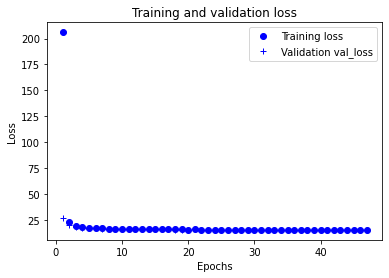

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b+', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()